# Model Validation - Tractors
<hr />

This notebook covers the Validation steps for the Trucks Model.

## Part 1: Cross Validation

We start with a review of the validation error, followed by decomposing the error into three parts:
- Bias
- Variance
- Noise

**Methods used for Cross validation:**

- Holdout Validation
<img src="https://datavedas.com/wp-content/uploads/2018/04/image001.jpg" width="400" height="100%" style="display: inline">
<br /><br /><br /><br />
- K-Fold Cross Validation
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/500px-K-fold_cross_validation_EN.svg.png" width="400" height="100%"  style="display: inline">
<br /><br /><br /><br />
- Repeated Random Test-Train Splits
  - The same as with Holdout Validation, we split the data 50% / 50% and do that randomly 10 times, using the average between the 10 repeats as the final score.
  
<hr />

## Part 2: Validate Model performance with different data samples

For this section, we create different Validation Data Sets to see how well the model performs given different data conditions. 

This test includes:
- **Seasonality:** Running the model against a specific 12 month year
- **Outlier Performance:** How well the model performs when we have a significant amount of outliers (Large Variance in data)
- **Change in Categorical Variable balance:** When certain categorial values change (such as Manufacturer), how well does the model predict against that change.

# Imports and Data Setup:
<hr />

In [36]:
# Import required libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import sklearn
import pickle
from statistics import variance 

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import model_selection

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold # --> Used for Stratification
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost

In [37]:
# Import Data to use
df = pd.read_pickle('../../data/df_tractorALL.pickle')
print(df.shape)
df.describe().transpose()


(23806, 43)


,count,mean,std,min,25%,50%,75%,max
accumulated_depreciation_amt,23806.0,5.690575e+04,1.212066e+04,19546.0,48388.75,55085.0,6.389525e+04,149900.0
vehicle_sam_class_cd,23806.0,1.469003e+02,1.542932e+01,130.0,140.00,140.0,1.700000e+02,170.0
sam_summary_class_cd,23806.0,3.230383e+02,4.599202e+00,320.0,320.00,320.0,3.300000e+02,330.0
veh_domicle_location_cd,23806.0,2.748478e+03,3.961474e+02,1328.0,2443.00,2686.0,3.172000e+03,3452.0
vehicle_disp_cond_cd,23806.0,1.481013e+01,1.218373e+01,10.0,10.00,10.0,1.000000e+01,50.0
days_to_outservice,23806.0,6.361438e+01,5.451695e+01,0.0,26.00,50.0,8.700000e+01,295.0
vehicle_age,23806.0,9.293539e+01,1.731348e+01,30.0,83.00,94.0,1.080000e+02,115.0
vehicle_gvw_class_cd,23806.0,7.982819e+00,2.199820e-01,1.0,8.00,8.0,8.000000e+00,8.0
drive_tire_size_cd,23806.0,1.034222e+03,2.097760e+02,123.0,1102.00,1102.0,1.102000e+03,1446.0
rear_axle_capacity,23806.0,3.623876e+04,7.183857e+03,2300.0,40000.00,40000.0,4.000000e+04,48000.0


In [38]:
df.columns

Index(['accumulated_depreciation_amt', 'vehicle_sam_class_cd',
       'sam_summary_class_cd', 'veh_domicle_location_cd',
       'vehicle_disp_cond_cd', 'days_to_outservice', 'vehicle_age',
       'vehicle_gvw_class_cd', 'drive_tire_size_cd', 'rear_axle_capacity',
       'transmission_model_id', 'engine_model_id', 'engine_horsepower',
       'transmission_speed_qn', 'axle_total_count', 'year_month_num',
       'net_vehicle_invest', 'proceeds', 'model_year', 'odomoter_sale',
       'accpt_date_num', 'sale_date_num', 'x0_A', 'x0_L', 'x0_T', 'x1_ALLI',
       'x1_FULL', 'x1_OTHER', 'x2_CAT', 'x2_CUMM', 'x2_DETR', 'x2_INTL',
       'x2_OTHER', 'x3_FRTL', 'x3_INTL', 'x3_OTHER', 'x4_2002', 'x4_2004',
       'x4_2007', 'x4_2010', 'x4_2013', 'x4_2014', 'x4_UNKNOWN'],
      dtype='object')

In [39]:
# Import Model(s) to use
filename = '../../models/tractorXGBoost_ALL.model'
model_XGB = pickle.load(open(filename, 'rb'))

filename = '../../models/tractorLGBMR_ALL.model'
model_LGBMR = pickle.load(open(filename, 'rb'))

filename = '../../models/tractorHGBR_ALL.model'
model_HGBR = pickle.load(open(filename, 'rb'))


In [40]:
model_XGB

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.5, tree_method='auto',
             verbosity=1)

In [41]:
model_LGBMR

LGBMRegressor(bagging_fraction=0.8, bagging_freq=15, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', is_unbalance=True, learning_rate=0.1,
              max_depth=8, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=400, n_jobs=-1, num_leaves=60,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              scoring='neg_mean_squared_error', silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [42]:
model_HGBR

HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=256, max_depth=6,
                              max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0)

## Data Splits and Setup

### 1. Standard Data Split for Cross Validation

In [43]:
#Original Model split with 66/33 for training and test. 

X = df.loc[:, df.columns != 'proceeds']
y = df['proceeds'].values
variables = df.columns[1:]

### Outlier Validation Data:

In [44]:
#    Split Data by year for the Validation Set.
#    1. Split Data by year
#    2. Plot each year to see the variance in data
#    3. Pick two years as hold out (for validation) that have the most variance
#    4. Save as validation data frames for use later



# Part 1:
<hr />

### Setup Variables To Store Model Performance 

In [45]:
# model_XGB
# model_LGBMR
# model_HGBR

MAE = {}
MSE = {}
SCORE = {}


In [46]:
# show the inputs and predicted outputs
def showPredVSActual(y_test,y_new,num):
    for i in range(num):
        print('Original: ${}\tPredicted: ${}\tError: {}%'.format(y_test[i], 
                                                          round(y_new[i]),
                                                          round((y_test[i]-y_new[i])/y_test[i]*100)))

### XG Boost Cross Validation

In [47]:
%%time
"""
    Holdout Validation Approach
"""
# Evaluate using a train and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1234)

model_XGB.fit(X_train, y_train)
result = model_XGB.score(X_test, y_test)
MAE["XGBoost_HVA"] = mean_absolute_error(y_test, model_XGB.predict(X_test))
MSE["XGBoost_HVA"] = mean_squared_error(y_test, model_XGB.predict(X_test))
SCORE["XGBoost_HVA"] = model_XGB.score(X_test, y_test)
y_new = model_XGB.predict(X_test)

print("Holdout Validation Accuracy:\t{}%\n".format(round(SCORE["XGBoost_HVA"]*100.0,2)))
print(showPredVSActual(y_test, y_new, 100))

Holdout Validation Accuracy:	88.26%

Original: $30000	Predicted: $32619.0	Error: -9.0%
Original: $16500	Predicted: $15818.0	Error: 4.0%
Original: $25800	Predicted: $23831.0	Error: 8.0%
Original: $55000	Predicted: $33223.0	Error: 40.0%
Original: $23500	Predicted: $25278.0	Error: -8.0%
Original: $50000	Predicted: $48266.0	Error: 3.0%
Original: $33000	Predicted: $28633.0	Error: 13.0%
Original: $39000	Predicted: $37898.0	Error: 3.0%
Original: $26500	Predicted: $27380.0	Error: -3.0%
Original: $23520	Predicted: $23570.0	Error: -0.0%
Original: $24250	Predicted: $24941.0	Error: -3.0%
Original: $35390	Predicted: $29597.0	Error: 16.0%
Original: $33625	Predicted: $29195.0	Error: 13.0%
Original: $40000	Predicted: $33999.0	Error: 15.0%
Original: $39411	Predicted: $38391.0	Error: 3.0%
Original: $27940	Predicted: $29013.0	Error: -4.0%
Original: $20000	Predicted: $24896.0	Error: -24.0%
Original: $45000	Predicted: $42230.0	Error: 6.0%
Original: $27000	Predicted: $29746.0	Error: -10.0%
Original: $38500	

In [48]:
%%time
"""
    K-fold Cross-Validation
"""
kfold = KFold(n_splits=5, random_state=1234)
kfresult = cross_val_score(model_XGB, X, y, cv=kfold)
SCORE["XGBoost_kf5"] = np.mean(kfresult)
print("KFold-5 Accuracy: {}% (std: {}%)".format(round(np.mean(kfresult)*100.0,2), round(np.std(kfresult)*100.0,2)))

KFold-5 Accuracy: 89.19% (std: 0.31%)
CPU times: user 2min 36s, sys: 50.7 ms, total: 2min 36s
Wall time: 2min 36s


In [49]:
%%time
"""
    Repeated Random Test-Train Splits
"""
kfold2 = ShuffleSplit(n_splits=10, test_size=0.50, random_state=1234)
ssresult = cross_val_score(model_XGB, X, y, cv=kfold2)
SCORE["XGBoost_SS"] = np.mean(ssresult)
print("Shuffle Split Accuracy: {}% (std: {}%)".format(round(np.mean(ssresult)*100.0,2), round(np.std(ssresult)*100.0,2)))

Shuffle Split Accuracy: 88.3% (std: 0.28%)
CPU times: user 3min 14s, sys: 47 ms, total: 3min 14s
Wall time: 3min 14s


## Hist. Gradient Boosted Regression Validation

In [50]:
%%time
"""
    Holdout Validation Approach
"""
# Evaluate using a train and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1234)

model_HGBR.fit(X_train, y_train)
result = model_HGBR.score(X_test, y_test)
MAE["HGBR_HVA"] = mean_absolute_error(y_test, model_HGBR.predict(X_test))
MSE["HGBR_HVA"] = mean_squared_error(y_test, model_HGBR.predict(X_test))
SCORE["HGBR_HVA"] = model_HGBR.score(X_test, y_test)
y_new = model_HGBR.predict(X_test)

print("Holdout Validation Accuracy:\t{}%\n".format(round(SCORE["HGBR_HVA"]*100.0,2)))
print(showPredVSActual(y_test, y_new, 100))

Holdout Validation Accuracy:	85.93%

Original: $30000	Predicted: $32265.0	Error: -8.0%
Original: $16500	Predicted: $16878.0	Error: -2.0%
Original: $25800	Predicted: $24257.0	Error: 6.0%
Original: $55000	Predicted: $34265.0	Error: 38.0%
Original: $23500	Predicted: $25761.0	Error: -10.0%
Original: $50000	Predicted: $42846.0	Error: 14.0%
Original: $33000	Predicted: $29529.0	Error: 11.0%
Original: $39000	Predicted: $35803.0	Error: 8.0%
Original: $26500	Predicted: $27895.0	Error: -5.0%
Original: $23520	Predicted: $23396.0	Error: 1.0%
Original: $24250	Predicted: $24195.0	Error: 0.0%
Original: $35390	Predicted: $31952.0	Error: 10.0%
Original: $33625	Predicted: $26313.0	Error: 22.0%
Original: $40000	Predicted: $32294.0	Error: 19.0%
Original: $39411	Predicted: $39026.0	Error: 1.0%
Original: $27940	Predicted: $30412.0	Error: -9.0%
Original: $20000	Predicted: $25562.0	Error: -28.0%
Original: $45000	Predicted: $41246.0	Error: 8.0%
Original: $27000	Predicted: $28761.0	Error: -7.0%
Original: $38500	

In [51]:
%%time
"""
    K-fold Cross-Validation
"""
kfold = KFold(n_splits=5, random_state=1234)
kfresult = cross_val_score(model_HGBR, X, y, cv=kfold)
SCORE["HGBR_kf5"] = np.mean(kfresult)
print("KFold-5 Accuracy: {}% (std: {}%)".format(round(np.mean(kfresult)*100.0,2), round(np.std(kfresult)*100.0,2)))

KFold-5 Accuracy: 86.49% (std: 0.48%)
CPU times: user 6.05 s, sys: 77.9 ms, total: 6.13 s
Wall time: 6.13 s


In [52]:
%%time
"""
    Repeated Random Test-Train Splits
"""
kfold2 = ShuffleSplit(n_splits=10, test_size=0.50, random_state=1234)
ssresult = cross_val_score(model_HGBR, X, y, cv=kfold2)
SCORE["HGBR_SS"] = np.mean(ssresult)
print("Shuffle Split Accuracy: {}% (std: {}%)".format(round(np.mean(ssresult)*100.0,2), round(np.std(ssresult)*100.0,2)))

Shuffle Split Accuracy: 85.98% (std: 0.25%)
CPU times: user 10.3 s, sys: 199 ms, total: 10.5 s
Wall time: 10.5 s


## Light GBM Validation

In [53]:
%%time
"""
    Holdout Validation Approach
"""
# Evaluate using a train and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1234)

model_LGBMR.fit(X_train, y_train)
result = model_LGBMR.score(X_test, y_test)
MAE["LGBM_HVA"] = mean_absolute_error(y_test, model_LGBMR.predict(X_test))
MSE["LGBM_HVA"] = mean_squared_error(y_test, model_LGBMR.predict(X_test))
SCORE["LGBM_HVA"] = model_LGBMR.score(X_test, y_test)
y_new = model_LGBMR.predict(X_test)

print("Holdout Validation Accuracy:\t{}%\n".format(round(SCORE["LGBM_HVA"]*100.0,2)))
print(showPredVSActual(y_test, y_new, 100))

Holdout Validation Accuracy:	88.47%

Original: $30000	Predicted: $32407.0	Error: -8.0%
Original: $16500	Predicted: $16391.0	Error: 1.0%
Original: $25800	Predicted: $24460.0	Error: 5.0%
Original: $55000	Predicted: $32898.0	Error: 40.0%
Original: $23500	Predicted: $24637.0	Error: -5.0%
Original: $50000	Predicted: $48258.0	Error: 3.0%
Original: $33000	Predicted: $29525.0	Error: 11.0%
Original: $39000	Predicted: $37393.0	Error: 4.0%
Original: $26500	Predicted: $28870.0	Error: -9.0%
Original: $23520	Predicted: $24516.0	Error: -4.0%
Original: $24250	Predicted: $25206.0	Error: -4.0%
Original: $35390	Predicted: $31768.0	Error: 10.0%
Original: $33625	Predicted: $25629.0	Error: 24.0%
Original: $40000	Predicted: $32095.0	Error: 20.0%
Original: $39411	Predicted: $35844.0	Error: 9.0%
Original: $27940	Predicted: $28402.0	Error: -2.0%
Original: $20000	Predicted: $25824.0	Error: -29.0%
Original: $45000	Predicted: $41286.0	Error: 8.0%
Original: $27000	Predicted: $29690.0	Error: -10.0%
Original: $38500	

In [54]:
%%time
"""
    K-fold Cross-Validation
"""
kfold = KFold(n_splits=5, random_state=1234)
kfresult = cross_val_score(model_LGBMR, X, y, cv=kfold)
SCORE["LGBM_kf5"] = np.mean(kfresult)
print("KFold-5 Accuracy: {}% (std: {}%)".format(round(np.mean(kfresult)*100.0,2), round(np.std(kfresult)*100.0,2)))

KFold-5 Accuracy: 89.63% (std: 0.33%)
CPU times: user 12.6 s, sys: 979 µs, total: 12.6 s
Wall time: 12.6 s


In [55]:
%%time
"""
    Repeated Random Test-Train Splits
"""
kfold2 = ShuffleSplit(n_splits=10, test_size=0.50, random_state=1234)
ssresult = cross_val_score(model_LGBMR, X, y, cv=kfold2)
SCORE["LGBM_SS"] = np.mean(ssresult)
print("Shuffle Split Accuracy: {}% (std: {}%)".format(round(np.mean(ssresult)*100.0,2), round(np.std(ssresult)*100.0,2)))

Shuffle Split Accuracy: 88.57% (std: 0.2%)
CPU times: user 24.3 s, sys: 7.11 ms, total: 24.3 s
Wall time: 24.3 s


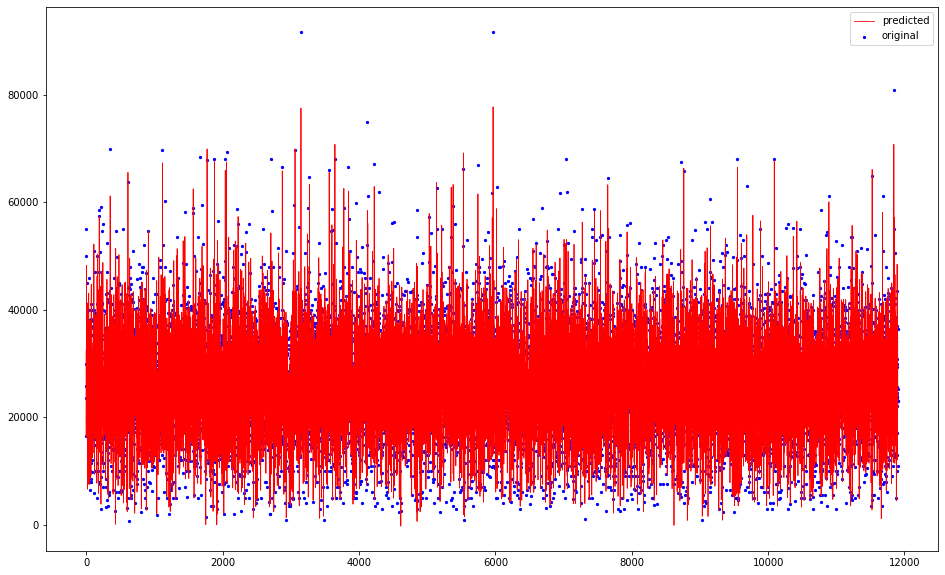

In [56]:
x_ax = range(len(y_test))
plt.figure(figsize=(16,10))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, model_LGBMR.predict(X_test), lw=0.8, color="red", label="predicted",)
plt.legend()
plt.show()

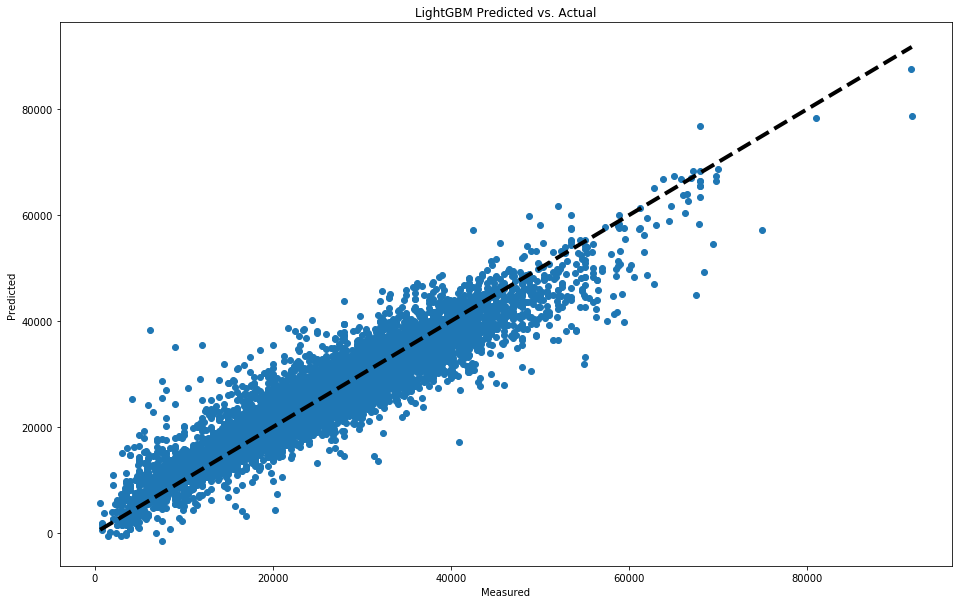

In [63]:
y_pred = cross_val_predict(model_LGBMR, X_test, y_test,cv=5)

fig, ax = plt.subplots(figsize=(16,10))
plt.gca().set_title('LightGBM Predicted vs. Actual')
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Text(0, 0.5, 'Frequency')

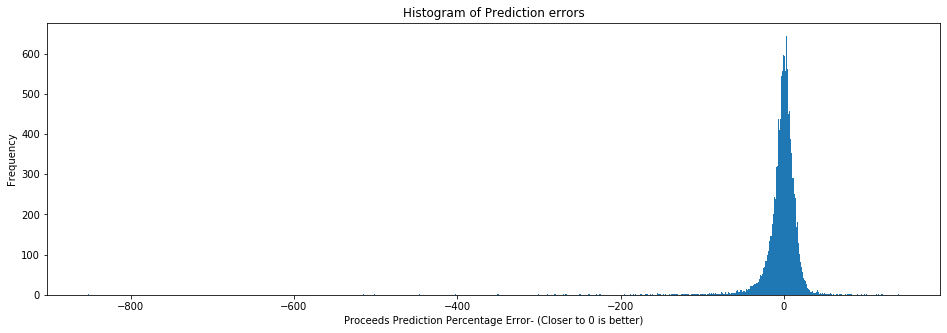

In [64]:
#diff = y_test - y_pred
diff = (y_test-y_pred)/y_test*100

plt.figure(figsize=(16,5))
plt.hist(diff, bins = 'auto')
plt.title('Histogram of Prediction errors')
plt.xlabel('Proceeds Prediction Percentage Error- (Closer to 0 is better)')
plt.ylabel('Frequency')

In [58]:
MAE

{'XGBoost_HVA': 2425.3865534799957,
 'HGBR_HVA': 2727.336133865237,
 'LGBM_HVA': 2401.2117324698847}

In [59]:
MSE

{'XGBoost_HVA': 11694859.592310404,
 'HGBR_HVA': 14020826.194578191,
 'LGBM_HVA': 11492135.91695167}

In [60]:
SCORE

{'XGBoost_HVA': 0.8826167836012225,
 'XGBoost_kf5': 0.8919168108181929,
 'XGBoost_SS': 0.8830291721146079,
 'HGBR_HVA': 0.8592706768048783,
 'HGBR_kf5': 0.864878435276245,
 'HGBR_SS': 0.8598064844715166,
 'LGBM_HVA': 0.8846515542511786,
 'LGBM_kf5': 0.8962692589915886,
 'LGBM_SS': 0.8856812929992313}

# Part 2:
<hr />
<b>Part 2: Validate Model performance with different data samples</b>

For this section, we create different Validation Data Sets to see how well the model performs given different data conditions.

<b>This test includes:</b>

Seasonality: Running the model against a specific 12 month year

Outlier Performance: How well the model performs when we have a significant amount of outliers (Large Variance in data)

Change in Categorical Variable balance: When certain categorial values change (such as Manufacturer), how well does the model predict against that change.

In [21]:
def coor_by_feature (feature,df_mr):
    col_names = df_mr.corr().columns.values
    for col, row in (df_mr.corr().abs() > 0.5).iteritems():
        if (col == feature) :
            print("*****\n{} \n CORR FEATURE(S): {}".format(col, col_names[row.values]))
            return

In [22]:
#Helper Functions

def change_value_year(df,start,end,change,col):
    condition = (df.sale_date_num >= start) & (df.sale_date_num < end)
#    condition = (df.sale_date_num >= start) & (df.sale_date_num < end)
    df.loc[condition, col] = df.loc[condition, col] * change
    return df

def holdout_year(df,start,end):
    condition = (df.sale_date_num>=start) & (df.sale_date_num<end)
    df_year_held = df.loc[condition]
    df_remaining = df.loc[~condition]    
    return df_year_held, df_remaining 



### 2. Seasonality Validation Data Split:

1. Split Data by year
2. Plot each year to see the variance in data
3. Pick two years as hold out (for validation) that have the most variance
4. Save as validation data frames for use later

### Check the distribution of the sale_date_num

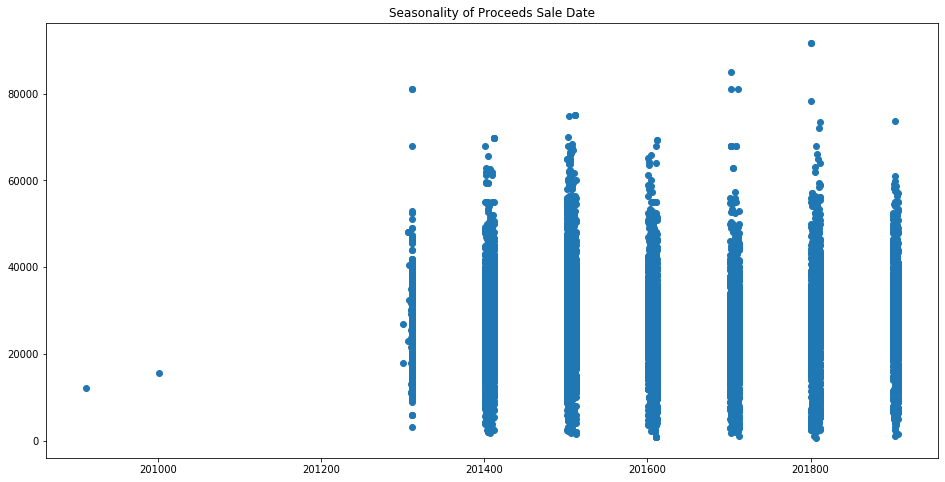

In [23]:
plt.scatter(df.sale_date_num,y)
plt.title('Seasonality of Proceeds Sale Date')
plt.gcf().set_size_inches((16, 8))    
plt.show()

**Note:**

Based on the above graph, we will stick to 2014 > data for validation in Part 2

<h2> Seasonality: model one year of data  

In [24]:
df_one_year, df_remain = holdout_year (df, 201601,201701)
df_one_year_Y  = np.array(df_one_year['proceeds'])
cols = df_one_year.columns[df_one_year.columns != 'proceeds']
df_one_year_X  = df_one_year[cols]


<h2> XGBOOST


In [25]:
# Evaluate using a train and a test set

X_train, X_test, y_train, y_test = train_test_split(df_one_year_X, df_one_year_Y, test_size=0.50, random_state=1234)

model_XGB.fit(X_train, y_train)
result = model_XGB.score(X_test, y_test)
MAE["XGBoost_HVA"] = mean_absolute_error(y_test, model_XGB.predict(X_test))
MSE["XGBoost_HVA"] = mean_squared_error(y_test, model_XGB.predict(X_test))
SCORE["XGBoost_HVA"] = model_XGB.score(X_test, y_test)
y_new = model_XGB.predict(X_test)

print("Model 1 Year Validation Accuracy:\t{}%\n".format(round(SCORE["XGBoost_HVA"]*100.0,2)))

print(showPredVSActual(y_test, y_new, 10))

Model 1 Year Validation Accuracy:	79.7%

Original: $25500	Predicted: $23743.0	Error: 7.0%
Original: $20000	Predicted: $21231.0	Error: -6.0%
Original: $25905	Predicted: $23996.0	Error: 7.0%
Original: $50622	Predicted: $42661.0	Error: 16.0%
Original: $32000	Predicted: $27980.0	Error: 13.0%
Original: $16500	Predicted: $26373.0	Error: -60.0%
Original: $28000	Predicted: $27789.0	Error: 1.0%
Original: $12005	Predicted: $11979.0	Error: 0.0%
Original: $29000	Predicted: $24407.0	Error: 16.0%
Original: $37000	Predicted: $37179.0	Error: -0.0%
None


<h2> Hist. Gradient Boosted Regression Validation

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_one_year_X, df_one_year_Y, test_size=0.50, random_state=1234)

model_HGBR.fit(X_train, y_train)
result = model_HGBR.score(X_test, y_test)
MAE["HGBR_HVA"] = mean_absolute_error(y_test, model_HGBR.predict(X_test))
MSE["HGBR_HVA"] = mean_squared_error(y_test, model_HGBR.predict(X_test))
SCORE["HGBR_HVA"] = model_HGBR.score(X_test, y_test)
y_new = model_HGBR.predict(X_test)

print("Model 1 year Validation Accuracy:\t{}%\n".format(round(SCORE["HGBR_HVA"]*100.0,2)))
print(showPredVSActual(y_test, y_new, 10))

Model 1 year Validation Accuracy:	78.9%

Original: $25500	Predicted: $22898.0	Error: 10.0%
Original: $20000	Predicted: $20719.0	Error: -4.0%
Original: $25905	Predicted: $23991.0	Error: 7.0%
Original: $50622	Predicted: $41493.0	Error: 18.0%
Original: $32000	Predicted: $28852.0	Error: 10.0%
Original: $16500	Predicted: $28044.0	Error: -70.0%
Original: $28000	Predicted: $29653.0	Error: -6.0%
Original: $12005	Predicted: $13338.0	Error: -11.0%
Original: $29000	Predicted: $26214.0	Error: 10.0%
Original: $37000	Predicted: $39049.0	Error: -6.0%
None


<h2> Light GBM Validation

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_one_year_X, df_one_year_Y, test_size=0.50, random_state=1234)

model_LGBMR.fit(X_train, y_train)
result = model_LGBMR.score(X_test, y_test)
MAE["LGBM_HVA"] = mean_absolute_error(y_test, model_LGBMR.predict(X_test))
MSE["LGBM_HVA"] = mean_squared_error(y_test, model_LGBMR.predict(X_test))
SCORE["LGBM_HVA"] = model_LGBMR.score(X_test, y_test)
y_new = model_LGBMR.predict(X_test)

print("Model 1 year Validation Accuracy:\t{}%\n".format(round(SCORE["LGBM_HVA"]*100.0,2)))
print(showPredVSActual(y_test, y_new, 10))

Model 1 year Validation Accuracy:	80.15%

Original: $25500	Predicted: $24361.0	Error: 4.0%
Original: $20000	Predicted: $18434.0	Error: 8.0%
Original: $25905	Predicted: $23063.0	Error: 11.0%
Original: $50622	Predicted: $40545.0	Error: 20.0%
Original: $32000	Predicted: $28261.0	Error: 12.0%
Original: $16500	Predicted: $27521.0	Error: -67.0%
Original: $28000	Predicted: $26728.0	Error: 5.0%
Original: $12005	Predicted: $13244.0	Error: -10.0%
Original: $29000	Predicted: $26528.0	Error: 9.0%
Original: $37000	Predicted: $38123.0	Error: -3.0%
None
